In [2]:
import proplot as pplt
import galsim
import numpy as np
import ngmix 
import metadetect
import yaml

In [3]:
CONFIG = yaml.safe_load("""\
  metacal:
    psf: fitgauss
    types: [noshear, 1p, 1m, 2p, 2m]
    use_noise_image: True

  psf:
    lm_pars:
      maxfev: 2000
      ftol: 1.0e-05
      xtol: 1.0e-05
    model: gauss

    # we try many times because if this fails we get no psf info
    # for the entire patch
    ntry: 10

  sx:

  weight:
    fwhm: 1.2  # arcsec

  meds:
    box_padding: 2
    box_type: iso_radius
    max_box_size: 53
    min_box_size: 33
    rad_fac: 2
    rad_min: 4

  # check for an edge hit
  bmask_flags: 1610612736  # 2**29 || 2**30

""")

In [4]:
def make_obs(
    *,
    n_grid=5,
    dim=235,
    buff=20,
    scale=0.2,
    psf_fwhm=0.9,
    hlr=0.5,
    nse=1e-7,
    star_dxdy=117,
    star_rad=1,
    n_stars=5,
    seed=10,
    shear=(0.02, 0.0),
    mcal_shear=(0.0, 0.0)
):
    rng = np.random.RandomState(seed=seed)
    n_gals = n_grid**2
    tot_dim = dim + 2*buff
    tot_cen = (tot_dim-1)/2
    gloc = (np.arange(n_grid) + 0.5) * (dim / n_grid) - dim/2
    gloc *= scale
    dx, dy = np.meshgrid(gloc, gloc)
    dx = dx.ravel() + rng.uniform(low=-0.5, high=0.5, size=n_gals) * scale
    dy = dy.ravel() + rng.uniform(low=-0.5, high=0.5, size=n_gals) * scale
    ds = np.arange(n_gals) / (n_gals-1) * 1.5 + 1
    gals = galsim.Sum([
        galsim.Exponential(
            half_light_radius=hlr * _ds
        ).shift(
            _dx, _dy
        ).shear(
            g1=shear[0], g2=shear[1]
        ).shear(
            g1=mcal_shear[0], g2=mcal_shear[1]
        )
        for _ds, _dx, _dy in zip(ds, dx, dy)
    ])
    psf = galsim.Gaussian(fwhm=psf_fwhm)
    objs = galsim.Convolve([gals, psf])
    im = objs.drawImage(nx=tot_dim, ny=tot_dim, scale=scale).array
    
    im += rng.normal(size=im.shape, scale=nse)
    nim = rng.normal(size=im.shape, scale=nse)
    
    psf_dim = 53
    psf_cen = (psf_dim-1)/2
    psf_im = psf.drawImage(nx=psf_dim, ny=psf_dim, scale=scale).array
    
    # make bmask
    bmask = np.zeros_like(im, dtype=np.int32)
    x, y = np.meshgrid(np.arange(tot_dim), np.arange(tot_dim))
    sdata = []
    for _ in range(n_stars):
        sr2 = np.power(10.0, rng.uniform(low=star_rad, high=star_rad+0.2))**2
        sx = rng.uniform(low=-star_dxdy, high=star_dxdy) + tot_cen
        sy = rng.uniform(low=-star_dxdy, high=star_dxdy) + tot_cen
        dr2 = (x - sx)**2 + (y - sy)**2
        msk = dr2 < sr2
        bmask[msk] |= 2**0
        im[msk] = 0
        sdata.append((sx, sy, np.sqrt(sr2)))
    
    psf_obs = ngmix.Observation(
        image=psf_im,
        weight=np.ones_like(psf_im)/ nse**2,
        jacobian=ngmix.DiagonalJacobian(scale=scale, row=psf_cen, col=psf_cen)
    )
    wgt = np.ones_like(im) / nse**2
    msk = bmask != 0
    wgt[msk] = 0.0
    mfrac = np.zeros_like(im)
    mfrac[msk] = 1.0
    obs = ngmix.Observation(
        image=im,
        noise=nim,
        weight=wgt,
        bmask=bmask,
        ormask=bmask,
        jacobian=ngmix.DiagonalJacobian(scale=scale, row=tot_cen, col=tot_cen),
        psf=psf_obs
    )
    obs.mfrac = mfrac
    mbobs = ngmix.MultiBandObsList()
    obsl = ngmix.ObsList()
    obsl.append(obs)
    mbobs.append(obsl)
    mbobs.meta["sdata"] = sdata
    return mbobs

In [11]:
import copy
from metadetect.detect import MEDSifier
from ngmix.gaussmom import GaussMom
import esutil

def meas_mbmeds(mbobs, maskflags=1, meds_config=None):
    # meas PSF
    mom = GaussMom(fwhm=1.2, obs=mbobs[0][0].psf)
    mom.go()
    res = mom.result
    psf_T = res['T']
    
    if meds_config is None:
        meds_config = copy.deepcopy(CONFIG["meds"])
    mfier = MEDSifier(
        mbobs, 
        sx_config=None, 
        meds_config=meds_config, 
        maskflags=maskflags
    )
    mbmeds = mfier.get_multiband_meds()
    d = []
    dt = [
        ("flags", "i4"),
        ("g1", "f8"),
        ("g2", "f8"),
        ("s2n", "f8"),
        ("x", "f8"),
        ("y", "f8"),
        ('T_ratio', 'f8'),
    ]
    for i, _mbobs in enumerate(mbmeds.get_mbobs_list()):
        if len(_mbobs) > 0 and len(_mbobs[0]) > 0:
            obs = _mbobs[0][0]
            cen = int((obs.bmask.shape[0]-1)/2)
            mw = 4
            if np.any((obs.bmask[cen-mw:cen+mw, cen-mw:cen+mw] & maskflags) != 0):
                continue
            mom = GaussMom(fwhm=1.2, obs=obs)
            mom.go()
            res = mom.result
            if res["flags"] == 0:
                d.append((
                    res["flags"], 
                    res["e"][0], res["e"][1], 
                    res["s2n"], 
                    mfier.cat["x"][i], mfier.cat["y"][i],
                    res['T'] / psf_T
                ))
            else:
                d.append((
                    res["flags"], 
                    -9999, -9999, 
                    -9999, 
                    mfier.cat["x"][i], mfier.cat["y"][i],
                    -9999,
                ))
    return np.array(d, dtype=dt), mbobs
    

In [12]:
import esutil as eu
import tqdm
import joblib
import sys
from mdet_tools import estimate_m_and_c

def _cut_cat(d):
    return d[
        (d["flags"] == 0) 
        & (d["s2n"] > 100)
        & (d["T_ratio"] > 1.2)
    ]

def _meas_m(n_stars, s, step):
    kwargs = {"n_stars": n_stars, "seed": s}
    _d, mbobs = meas_mbmeds(make_obs(shear=(0.02, 0.0), mcal_shear=(0, 0), **kwargs))
    _d1p, mbobs1p = meas_mbmeds(make_obs(shear=(0.02, 0.0), mcal_shear=(step, 0), **kwargs))
    _d1m, mbobs1m = meas_mbmeds(make_obs(shear=(0.02, 0.0), mcal_shear=(-step, 0), **kwargs))
    _d = _cut_cat(_d)
    _d1p = _cut_cat(_d1p)
    _d1m = _cut_cat(_d1m)

    if len(_d) > 0 and len(_d1p) > 0 and len(_d1m) > 0:
        g1 = np.mean(_d["g1"])
        g1p = np.mean(_d1p["g1"])
        g1m = np.mean(_d1m["g1"])
        g2 = np.mean(_d["g2"])
        g2p = np.mean(_d1p["g2"])
        g2m = np.mean(_d1m["g2"])
        pres = (g1p, g1m, g1, g2p, g2m, g2)
    else:
        return None, None

    kwargs = {"n_stars": n_stars, "seed": s}
    _d, mbobs = meas_mbmeds(make_obs(shear=(-0.02, 0.0), mcal_shear=(0, 0), **kwargs))
    _d1p, mbobs1p = meas_mbmeds(make_obs(shear=(-0.02, 0.0), mcal_shear=(step, 0), **kwargs))
    _d1m, mbobs1m = meas_mbmeds(make_obs(shear=(-0.02, 0.0), mcal_shear=(-step, 0), **kwargs))
    _d = _cut_cat(_d)
    _d1p = _cut_cat(_d1p)
    _d1m = _cut_cat(_d1m)

    if len(_d) > 0 and len(_d1p) > 0 and len(_d1m) > 0:
        g1 = np.mean(_d["g1"])
        g1p = np.mean(_d1p["g1"])
        g1m = np.mean(_d1m["g1"])
        g2 = np.mean(_d["g2"])
        g2p = np.mean(_d1p["g2"])
        g2m = np.mean(_d1m["g2"])
        mres = (g1p, g1m, g1, g2p, g2m, g2)
    else:
        return None, None
    
    return pres, mres


def meas_m(n_stars, n_jobs=100, seed=10, step=0.01):
    ds = []
    d1ps = []
    d1ms = []
    ms = []
    seeds = np.random.RandomState(seed=seed).randint(size=n_jobs, low=1, high=2**28)
    jobs = [
        joblib.delayed(_meas_m)(n_stars, s, step)
    
        for s in seeds
    ]
    with joblib.Parallel(n_jobs=-1, verbose=5, backend="loky", max_nbytes=0) as par:
        res = par(jobs)
    sys.stderr.flush()
    sys.stdout.flush()
    
    pres = [r[0] for r in res]
    mres = [r[1] for r in res]
    
    m, merr, c, cerr = estimate_m_and_c(
        pres,
        mres,
        0.02,
        jackknife=200 if n_jobs > 1000 else None,
    )
    
    return m, merr, c, cerr

n_stars = 20
m, merr, c, cerr = meas_m(n_stars, seed=20, n_jobs=100)

print("star density: %s [num per arcmin^2]" % (n_stars / (235*0.20/60)**2))
mstr = "m +/- merr: %0.6f +/- %0.6f [10^(-3), 3sigma]" % (m/1e-3, 3*merr/1e-3)
print(mstr)

cstr = "c +/- cerr: %0.6f +/- %0.6f [10^(-5), 3sigma]" % (c/1e-3, 3*cerr/1e-3)
print(cstr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
                                                                               

star density: 32.593933906745136 [num per arcmin^2]
m +/- merr: -27.555880 +/- 89.789580 [10^(-3), 3sigma]
c +/- cerr: -13.686243 +/- 16674.646620 [10^(-5), 3sigma]


((0.0, 275.0), (0.0, 275.0), (0.0, 275.0))

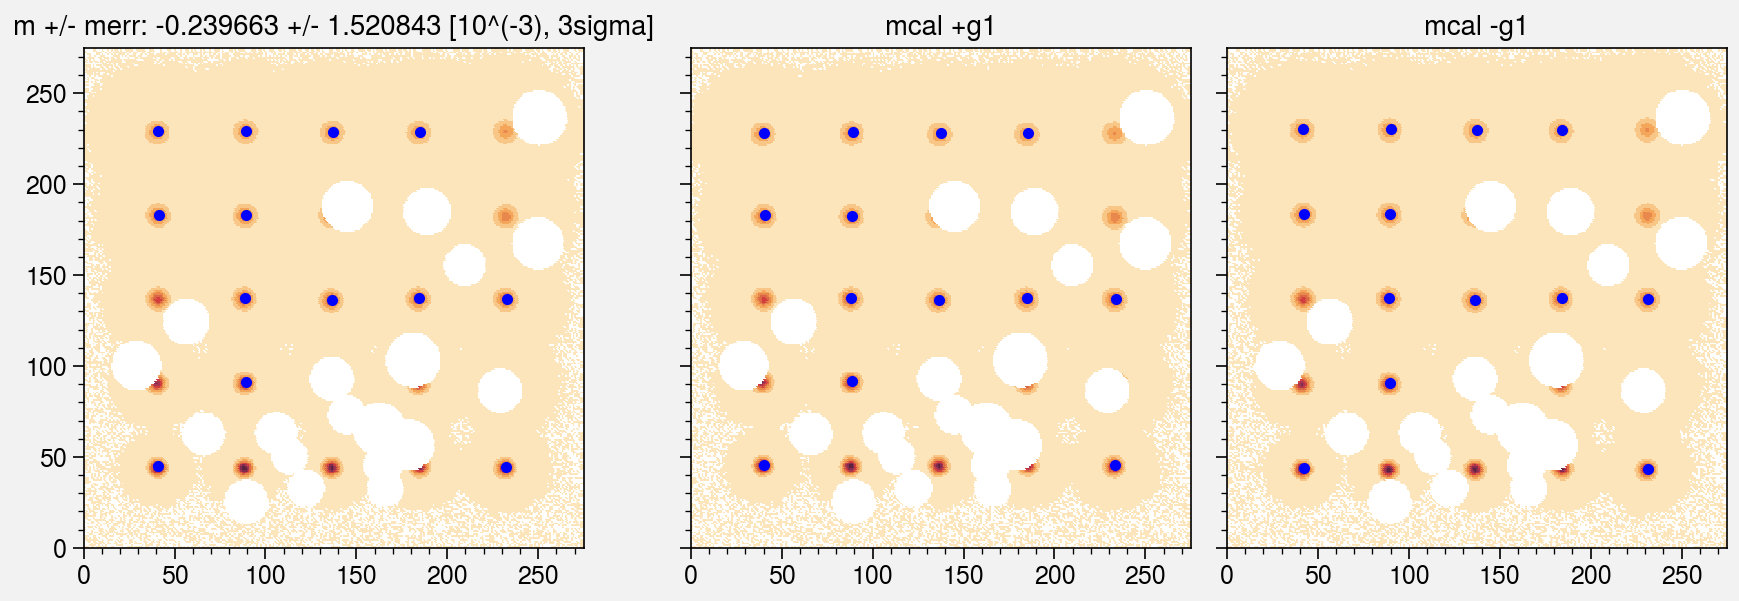

In [10]:
step = 0.01
s = 100
kwargs = {"n_stars": n_stars, "seed": s}
d, mbobs = meas_mbmeds(make_obs(mcal_shear=(0, 0), **kwargs))
d1p, mbobs1p = meas_mbmeds(make_obs(mcal_shear=(step, 0), **kwargs))
d1m, mbobs1m = meas_mbmeds(make_obs(mcal_shear=(-step, 0), **kwargs))
d = _cut_cat(d)
d1p = _cut_cat(d1p)
d1m = _cut_cat(d1m)

fig, axs = pplt.subplots(nrows=1, ncols=3, sharex=3, sharey=3)
axs[0].pcolormesh(mbobs[0][0].image)
axs[0].plot(d["x"], d["y"], '.b')
axs[0].set_title(mstr)

axs[1].pcolormesh(mbobs1p[0][0].image)
axs[1].plot(d1p["x"], d1p["y"], '.b')
axs[1].set_title("mcal +g1")

axs[2].pcolormesh(mbobs1m[0][0].image)
axs[2].plot(d1m["x"], d1m["y"], '.b')
axs[2].set_title("mcal -g1")

axs.set_xlim(0, mbobs[0][0].image.shape[1])
axs.set_ylim(0, mbobs[0][0].image.shape[0])